In [1]:
using StatsBase
using Plots
using JLD2
using Graphs
# using SimpleWeightedGraphs
using BlossomV

In [2]:
function initialstate(L::Int)
    ρ = zeros(Bool,L,L)
    return ρ
end

function noiselayer(ρ::AbstractMatrix, p::Float64)
    L = size(ρ)[1]
    noise = rand(L,L) .< p
    return ρ .⊻ noise
end

function magnetization(ρ::AbstractMatrix)
    return mean(ρ)
end

magnetization (generic function with 1 method)

In [3]:
function measure(ρ::AbstractMatrix, q::Float64)
    vertical_checks = noiselayer(ρ .⊻ circshift(ρ,(-1,0)),q)
    horizontal_checks = noiselayer(ρ .⊻ circshift(ρ,(0,-1)),q)
    return vertical_checks, horizontal_checks
end

function toom(ρ::AbstractMatrix, checks::Tuple)
    vertical_checks, horizontal_checks = checks
    ρ = ρ .⊻ (vertical_checks .& horizontal_checks)
    return ρ
end

function MV(ρ::AbstractMatrix, checks::Tuple)
    vertical_checks, horizontal_checks = checks
    total = vertical_checks + horizontal_checks + circshift(vertical_checks,(1,0)) + circshift(horizontal_checks,(0,1))
    ρ = ρ .⊻ (total .> 2)
    return ρ
end

MV (generic function with 1 method)

In [4]:
function MV(ρ::AbstractMatrix)
    L = size(ρ)[1]
    updates = zeros(Bool,L,L)
    for i in 1:L
        for j in 1:L
            vote = ρ[i,j] + ρ[i,mod1(j-1,L)] + ρ[i,mod1(j+1,L)] + ρ[mod1(i-1,L),j] + ρ[mod1(i+1,L),j]
            if vote >= 3
                updates[i,j] = ρ[i,j] != true
            else
                updates[i,j] = ρ[i,j] != false
            end
        end
    end

    return ρ .⊻ updates
end

MV (generic function with 2 methods)

In [5]:
function detect_charges(vertical_checks::AbstractMatrix, horizontal_checks::AbstractMatrix)
    L = size(vertical_checks)[1]
    sites = vertical_checks .⊻ horizontal_checks .⊻ circshift(vertical_checks,(0,-1)) .⊻ circshift(horizontal_checks,(-1,0))
    return [(j,i) for i in 1:L, j in 1:L][sites]
end

function distance(L::Int, p1::Tuple{Int,Int}, p2::Tuple{Int,Int})
    x1, y1 = p1
    x2, y2 = p2
    dx = min(abs(x2-x1),L-abs(x2-x1))
    dy = min(abs(y2-y1),L-abs(y2-y1))
    return dx, dy, abs(x2-x1) > L-abs(x2-x1), abs(y2-y1) > L-abs(y2-y1)
end

function match_charges(L::Int, charges::Vector; depth=50)
    subgraph = complete_graph(length(charges))
    weights = Dict{Edge,Float64}()
    for i in 1:length(charges)-1
        for j in i+1:length(charges)
            dx, dy, _, _ = distance(L, charges[i], charges[j])
            weights[Edge(i, j)] = dx+dy
        end
    end

    match = minimum_weight_perfect_matching(subgraph, weights, depth)
    return match
end

function heal(vertical_checks::AbstractMatrix, horizontal_checks::AbstractMatrix)
    L = size(vertical_checks)[1]
    charges = detect_charges(vertical_checks, horizontal_checks) 
    if length(charges) == 0
        return vertical_checks, horizontal_checks
    end
    pairings = match_charges(L, charges)
    paired = Int[]
    
    vertical_flips = BitMatrix(zeros(Bool, L, L))
    horizontal_flips = BitMatrix(zeros(Bool, L, L))
    for i in 1:length(charges)
        if i in paired
            continue
        end
        j = pairings.mate[i]
        push!(paired, j)
        
        dx, dy, x_loop, y_loop = distance(L, charges[i], charges[j])
        x_dir = (-1)^((charges[i][1] > charges[j][1]) ⊻ x_loop)
        y_dir = (-1)^((charges[i][2] > charges[j][2]) ⊻ y_loop)
    
        
        
        y_steps = sample(1:dx+dy, dy, replace=false)
        
        pos = charges[i]
        for step in 1:dx+dy
            x, y = pos
            if step in y_steps
                if y_dir == 1
                    horizontal_flips[mod1(y+1,L),x] ⊻= true
                else
                    horizontal_flips[y,x] ⊻= true
                end
                pos = (x, mod1(y+y_dir,L))
            else
                if x_dir == 1
                    vertical_flips[y,mod1(x+1,L)] ⊻= true
                else
                    vertical_flips[y,x] ⊻= true
                end
                pos = (mod1(x+x_dir,L), y)
            end
        end
    end
    return vertical_checks .⊻ vertical_flips, horizontal_checks .⊻ horizontal_flips
end

function build_correction(vertical_checks::AbstractMatrix, horizontal_checks::AbstractMatrix)
    L = size(vertical_checks)[1]
    domains = BitMatrix(zeros(Bool, L, L))
    for y in 1:L
        for x in 2:L
            domains[y,x] = domains[y,x-1] ⊻ horizontal_checks[y,x-1]
        end
        if y < L
            domains[y+1,1] = domains[y,1] ⊻ vertical_checks[y,1]
        end
    end
    
    if mean(domains) <= 0.5
        return domains
    else
        return true .⊻ domains
    end
end

function mwpm(ρ::AbstractMatrix, checks::Tuple)
    vertical_checks, horizontal_checks = checks
    ρ = ρ .⊻ build_correction(heal(vertical_checks, horizontal_checks)...)
    return ρ
end

mwpm (generic function with 1 method)

In [6]:
ρ = [0 0 0 0;
     0 0 0 0;
     1 1 1 1;
     1 1 1 1]
vertical_checks, horizontal_checks = measure(ρ, 0.0)
vertical_checks = [0 0 0 0;
                   1 1 1 1;
                   0 0 0 0;
                   0 0 0 0]
horizontal_checks = [0 0 0 0;
                     0 0 0 0;
                     0 0 0 0;
                     0 0 0 0]
new_vertical_checks, new_horizontal_checks = heal(Bool.(vertical_checks), Bool.(horizontal_checks))

(Bool[0 0 0 0; 1 1 1 1; 0 0 0 0; 0 0 0 0], Bool[0 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 0])

In [7]:
detect_charges(vertical_checks, horizontal_checks)

BoundsError: BoundsError: attempt to access 4×4 Matrix{Tuple{Int64, Int64}} at index [[0 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 0]]

In [8]:
struct MatchingResult{U<:Real}
    weight::U
    mate::Vector{Int}
end

function minimum_weight_perfect_matching end

function minimum_weight_perfect_matching(
    g::Graph, w::Dict{E,U}, cutoff, kws...
) where {U<:Real,E<:Edge}
    wnew = Dict{E,U}()
    for (e, c) in w
        if c <= cutoff
            wnew[e] = c
        end
    end
    return minimum_weight_perfect_matching(g, wnew; kws...)
end

function minimum_weight_perfect_matching(
    g::Graph, w::Dict{E,U}; tmaxscale=10.0
) where {U<:AbstractFloat,E<:Edge}
    wnew = Dict{E,Int32}()
    cmax = maximum(values(w))
    cmin = minimum(values(w))

    tmax = typemax(Int32) / tmaxscale # /10 is kinda arbitrary,
    # hopefully high enough to not occur in overflow problems
    for (e, c) in w
        wnew[e] = round(Int32, (c - cmin) / max(cmax - cmin, 1) * tmax)
    end
    match = minimum_weight_perfect_matching(g, wnew)
    weight = zero(U)
    for i in 1:nv(g)
        j = match.mate[i]
        if j > i
            weight += w[E(i, j)]
        end
    end
    return MatchingResult(weight, match.mate)
end

function minimum_weight_perfect_matching(g::Graph, w::Dict{E,U}) where {U<:Integer,E<:Edge}
    m = BlossomV.Matching(nv(g))
    for (e, c) in w
        BlossomV.add_edge(m, src(e) - 1, dst(e) - 1, c)
    end
    BlossomV.solve(m)

    mate = fill(-1, nv(g))
    totweight = zero(U)
    for i in 1:nv(g)
        j = BlossomV.get_match(m, i - 1) + 1
        mate[i] = j <= 0 ? -1 : j
        if i < j
            totweight += w[Edge(i, j)]
        end
    end
    return MatchingResult(totweight, mate)
end

minimum_weight_perfect_matching (generic function with 3 methods)

In [9]:
function MVsample(L::Int, T::Int, p::Float64, q::Float64)
    ρ = initialstate(L)
    Ms = zeros(Float64, T+1)

    Ms[1] = magnetization(ρ)

    for t in 1:T
        ρ = noiselayer(ρ, p)
        checks = measure(ρ, q)
        ρ = MV(ρ, checks)
        Ms[t+1] = magnetization(ρ)
    end
    return Ms
end

function TOOMsample(L::Int, T::Int, p::Float64, q::Float64)
    ρ = initialstate(L)
    Ms = zeros(Float64, T+1)

    Ms[1] = magnetization(ρ)

    for t in 1:T
        ρ = noiselayer(ρ, p)
        checks = measure(ρ, q)
        ρ = toom(ρ, checks)
        Ms[t+1] = magnetization(ρ)
    end
    return Ms
end

function MWPMsample(L::Int, T::Int, p::Float64, q::Float64)
    ρ = initialstate(L)
    Ms = zeros(Float64, T+1)

    Ms[1] = magnetization(ρ)

    for t in 1:T
        ρ = noiselayer(ρ, p)
        checks = measure(ρ, q)
        ρ = mwpm(ρ, checks)
        Ms[t+1] = magnetization(ρ)
    end
    return Ms
end

MWPMsample (generic function with 1 method)

In [10]:
function MVsample(L::Int, T::Int, p::Float64, q::Float64, samples::Int)
    M1s = zeros(Float64, T+1)
    M2s = zeros(Float64, T+1)
    for _ in 1:samples
        Ms = MVsample(L, T, p, q)
        M1s .+= Ms
        M2s .+= Ms.^2
    end
    M1s ./= samples
    M2s ./= samples
    return M1s, M2s
end

function TOOMsample(L::Int, T::Int, p::Float64, q::Float64, samples::Int)
    M1s = zeros(Float64, T+1)
    M2s = zeros(Float64, T+1)
    for _ in 1:samples
        Ms = TOOMsample(L, T, p, q)
        M1s .+= Ms
        M2s .+= Ms.^2
    end
    M1s ./= samples
    M2s ./= samples
    return M1s, M2s
end

function MWPMsample(L::Int, T::Int, p::Float64, q::Float64, samples::Int)
    M1s = zeros(Float64, T+1)
    M2s = zeros(Float64, T+1)
    for _ in 1:samples
        Ms = MWPMsample(L, T, p, q)
        M1s .+= Ms
        M2s .+= Ms.^2
    end
    M1s ./= samples
    M2s ./= samples
    return M1s, M2s
end


MWPMsample (generic function with 2 methods)

In [154]:
function MVtoMWPMsample(L::Int, T::Int, p::Float64, q::Float64)
    ρ = initialstate(L)
    Ms = zeros(Float64, 2T+1)

    Ms[1] = magnetization(ρ)

    for t in 1:T
        ρ = noiselayer(ρ, p)
        checks = measure(ρ, q)
        ρ = MV(ρ, checks)
        Ms[t+1] = magnetization(ρ)
    end
    for t in 1:T
        ρ = noiselayer(ρ, p)
        checks = measure(ρ, q)
        ρ = mwpm(ρ, checks)
        Ms[T+t+1] = magnetization(ρ)
    end
    return Ms
end

function MVtoMWPMsample(L::Int, T::Int, p::Float64, q::Float64, samples::Int)
    M1s = zeros(Float64, 2T+1)
    M2s = zeros(Float64, 2T+1)
    for _ in 1:samples
        Ms = MVtoMWPMsample(L, T, p, q)
        M1s .+= Ms
        M2s .+= Ms.^2
    end
    M1s ./= samples
    M2s ./= samples
    return M1s, M2s
end


MVtoMWPMsample (generic function with 2 methods)

In [155]:
# MVtoMWPMdata = Dict{Tuple{Int64,Int64,Float64,Float64},Tuple{Vector{Float64},Vector{Float64}}}()

In [156]:
for p in [0.08]
    q = p
    samples = 100

    for L in 4:4:12
        T = L^3

        M1s, M2s = MVtoMWPMsample(L, T, p, q, samples)
        MVtoMWPMdata[(L, T, p, q)] = (M1s, M2s)
    end
end

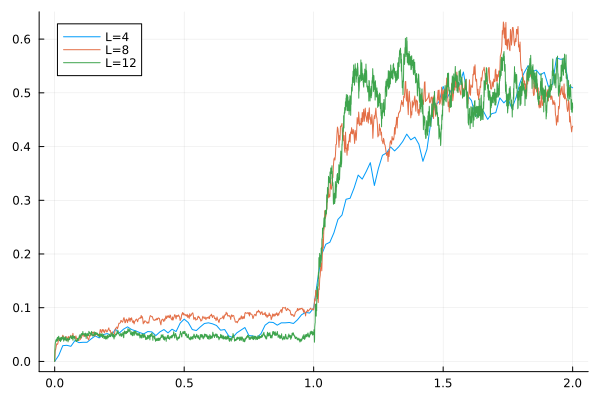

In [157]:
p = 0.08
q = p

plt = plot()

for L in 4:4:12
    T = L^3
    xs = collect(0:2T)/L^3
    ys = MVtoMWPMdata[(L, T, p, q)][1]
    plot!(plt, xs, ys, label="L=$L")
end
plt

In [11]:
MVdata = Dict{Tuple{Int64,Int64,Float64,Float64},Tuple{Vector{Float64},Vector{Float64}}}()
# TOOMdata = Dict{Tuple{Int64,Int64,Float64,Float64},Tuple{Vector{Float64},Vector{Float64}}}()
# MWPMdata = Dict{Tuple{Int64,Int64,Float64,Float64},Tuple{Vector{Float64},Vector{Float64}}}()

Dict{Tuple{Int64, Int64, Float64, Float64}, Tuple{Vector{Float64}, Vector{Float64}}}()

In [ ]:
# jldsave("25_08_05.jld2";  MVdata, TOOMdata, MWPMdata)

In [15]:
q = 0.1
for p in 0.0:0.02:0.2
    samples = 10000

    for L in 4:4:12
        T = L^3

        M1s, M2s = MVsample(L, T, p, q, samples)
        MVdata[(L, T, p, q)] = (M1s, M2s)
    end
end

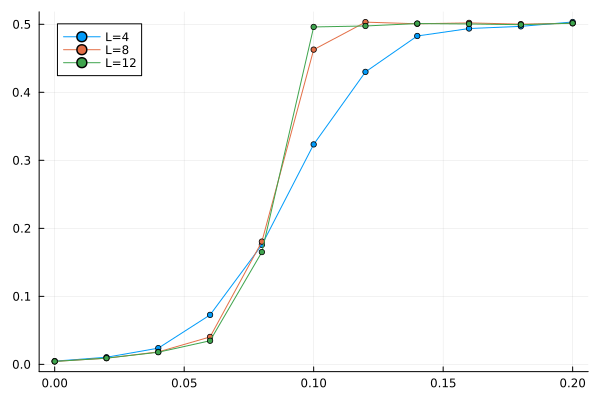

In [17]:
plt = plot()

for L in 4:4:12
    T = L^3
    xs = 0.0:0.02:0.2
    ys = [MVdata[(L, T, x, 0.1)][1][end] for x in xs]
    plot!(plt, xs, ys, label="L=$L", m=3)
end
plt

In [ ]:
q = 0.01
for p in 0.0:0.02:0.2
    samples = 1000

    for L in 4:4:12
        T = L^3

        M1s, M2s = TOOMsample(L, T, p, q, samples)
        TOOMdata[(L, T, p, q)] = (M1s, M2s)
    end
end

In [ ]:
q = 0.01
for p in 0.0:0.02:0.5
    samples = 10

    for L in 4:4:12
        T = L^3

        M1s, M2s = MWPMsample(L, T, p, q, samples)
        MWPMdata[(L, T, p, q)] = (M1s, M2s)
    end
end

In [142]:
for p in 0.0:0.01:0.1
    q = p
    samples = 400

    for L in 4:4:12
        T = L^3

        M1s, M2s = MWPMsample(L, T, p, q, samples)
        MWPMdata[(L, T, p, q)] = (M1s, M2s)
    end
end

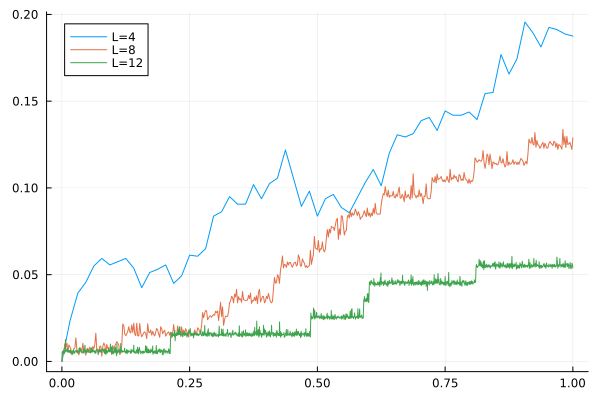

In [122]:
p = 0.04
q = p

plt = plot()

for L in 4:4:12
    T = L^3
    xs = collect(0:T)/L^3
    ys = MWPMdata[(L, T, p, q)][1]
    plot!(plt, xs, ys, label="L=$L")
end
plt

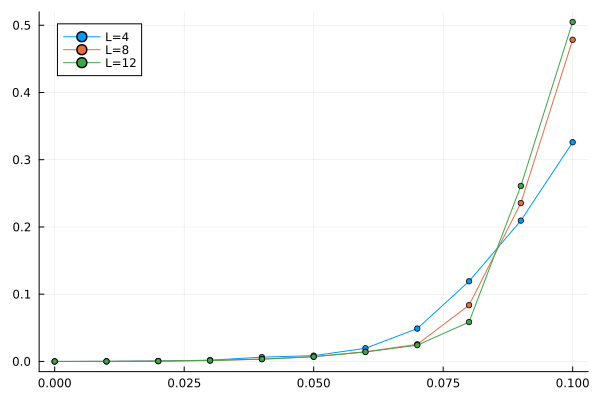

In [86]:
plt = plot()

for L in 4:4:12
    T = L^3
    xs = 0.0:0.01:0.1
    ys = [MVdata[(L, T, x, x)][1][end] for x in xs]
    plot!(plt, xs, ys, label="L=$L", m=3)
end
plt

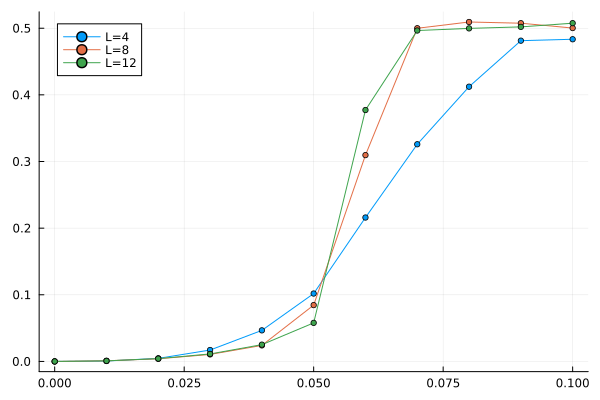

In [110]:
plt = plot()

for L in 4:4:12
    T = L^3
    xs = 0.0:0.01:0.1
    ys = [TOOMdata[(L, T, x, x)][1][end] for x in xs]
    plot!(plt, xs, ys, label="L=$L", m=3)
end
plt

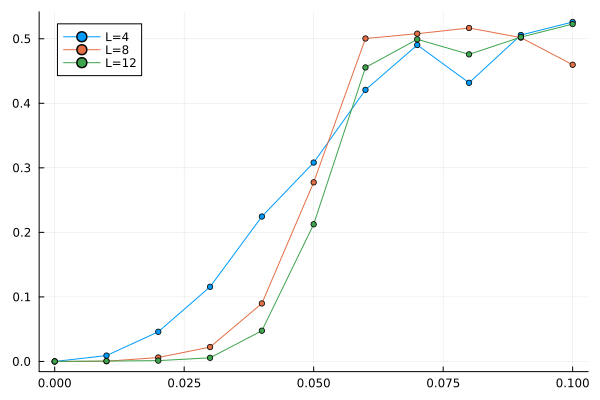

In [143]:
plt = plot()

for L in 4:4:12
    T = L^3
    xs = 0.0:0.01:0.1
    ys = [MWPMdata[(L, T, x, x)][1][end] for x in xs]
    plot!(plt, xs, ys, label="L=$L", m=3)
end
plt

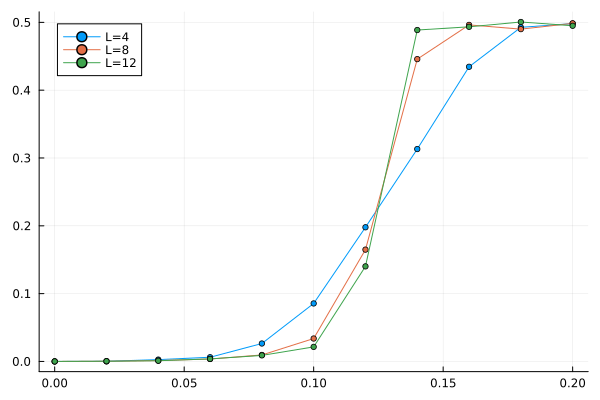

In [115]:
plt = plot()

for L in 4:4:12
    T = L^3
    xs = 0.0:0.02:0.2
    ys = [MVdata[(L, T, x, 0.01)][1][end] for x in xs]
    plot!(plt, xs, ys, label="L=$L", m=3)
end
plt

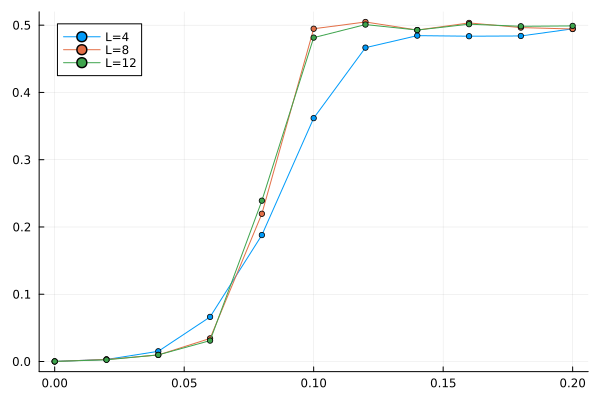

In [116]:
plt = plot()

for L in 4:4:12
    T = L^3
    xs = 0.0:0.02:0.2
    ys = [TOOMdata[(L, T, x, 0.01)][1][end] for x in xs]
    plot!(plt, xs, ys, label="L=$L", m=3)
end
plt

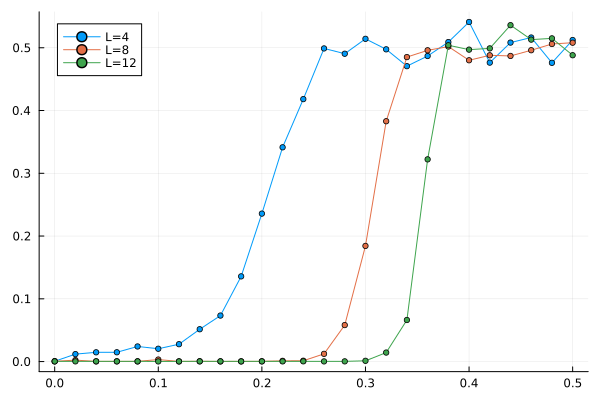

In [137]:
plt = plot()

for L in 4:4:12
    T = L^3
    xs = 0.0:0.02:0.5
    ys = [MWPMdata[(L, T, x, 0.01)][1][end] for x in xs]
    plot!(plt, xs, ys, label="L=$L", m=3)
end
plt

In [31]:
L = 4
T = L^3
p = 0.1
q = 0.1
Ms = MVsample(L, T, p, q)

65-element Vector{Float64}:
 0.0
 0.0
 0.0625
 0.0625
 0.125
 0.125
 0.1875
 0.125
 0.125
 0.0
 ⋮
 0.3125
 0.5
 0.3125
 0.5
 0.4375
 0.8125
 0.8125
 0.9375
 1.0